## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

import torch
import numpy as np

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import *
from dataMethods import DataProcessorFNO
from torch_fno2d import FNO2D

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_Y_components = 2 # displacement in 2D

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'LinearElasticity'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 2])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 2])


## Create model and train the network

In [4]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
model_save_data_and_info_file = model_save_path + 'data_and_info'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Number of trainable parameters: 154982


In [5]:
# save the data and info
data_to_save = data.get_data_to_save()
np.savez(model_save_data_and_info_file + '.npz', \
             data_to_save = data_to_save, \
             num_train = num_train, num_test = num_test, \
             num_Y_components = num_Y_components, \
             num_layers = num_layers, \
             width = width, \
             fourier_modes1 = fourier_modes1, \
             fourier_modes2 = fourier_modes2, \
             epochs = epochs, \
             batch_size = batch_size, \
             lr = lr)


In [6]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154982 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 5.538e-01, Test Loss (l2 squared): 2.004e-01, Time (sec): 10.513
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 3.761e-03, Test Loss (l2 squared): 3.569e-03, Time (sec): 9.948
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 2.245e-03, Test Loss (l2 squared): 3.193e-03, Time (sec): 9.913
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
---

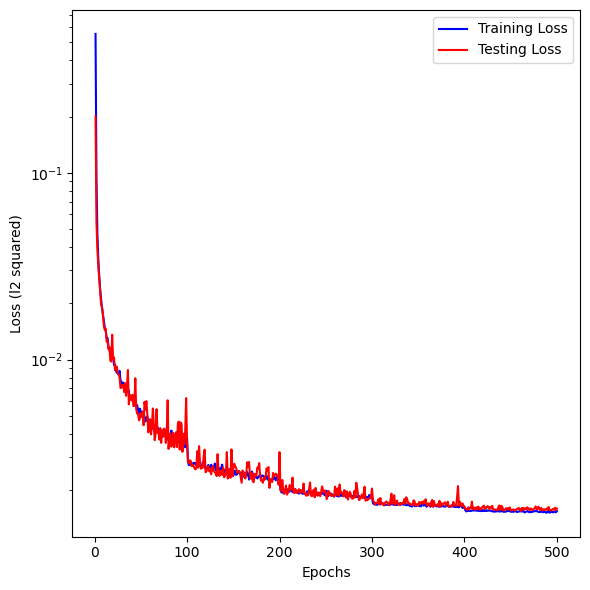

In [14]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

# Save the model

In [15]:
# not needed as the model will be saved at the end of training
torch.save(model, model_save_file)

## Test and plot the output of network

In [16]:
# load the model
model = torch.load(model_save_file)
print('Model loaded from:', model_save_file)
print('Model:', model)

Model loaded from: /home/prashant/Dropbox/Work/Simulations/neuralnet_works/error_corrector_direction/neural_operators_survey/problems/linear_elasticity/FNO/Results_implement2/FNO/model.pkl
Model: FNO2D(
  (fno_layers): ModuleList(
    (0-2): 3 x FNO2DLayer(
      (w): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (input_projector): Linear(in_features=3, out_features=20, bias=True)
  (output_projector): Linear(in_features=20, out_features=2, bias=True)
)


/tmp/ipykernel_1524878/4118623201.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_file)


In [17]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 2), test_pred shape: (1000, 51, 51, 2)
a shape: (1000, 5202), b shape: (1000, 5202)
Num tests:  1000, Mean Loss (rel l2): 5.102e-02, Std Loss (rel l2): 2.382e-02


In [18]:
i_plot = 0
i_pred = Y_test_pred[i_plot]
i_truth = Y_test[i_plot]
i_m_test = data.X_test[i_plot]
print('i_pred shape: {}, i_truth shape: {}, i_m_test shape: {}'.format(i_pred.shape, i_truth.shape, i_m_test.shape))

i_pred shape: (51, 51, 2), i_truth shape: (51, 51, 2), i_m_test shape: torch.Size([51, 51, 3])


In [19]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:,0], bc_node_ids[:,1], 0] = bc_value
    u[bc_node_ids[:,0], bc_node_ids[:,1], 1] = bc_value
    return u

i_plot =    18, error (rel l2): 2.519e-04
i_plot =   939, error (rel l2): 3.371e-04
i_plot =   532, error (rel l2): 2.028e-04
i_plot =   671, error (rel l2): 2.086e-04


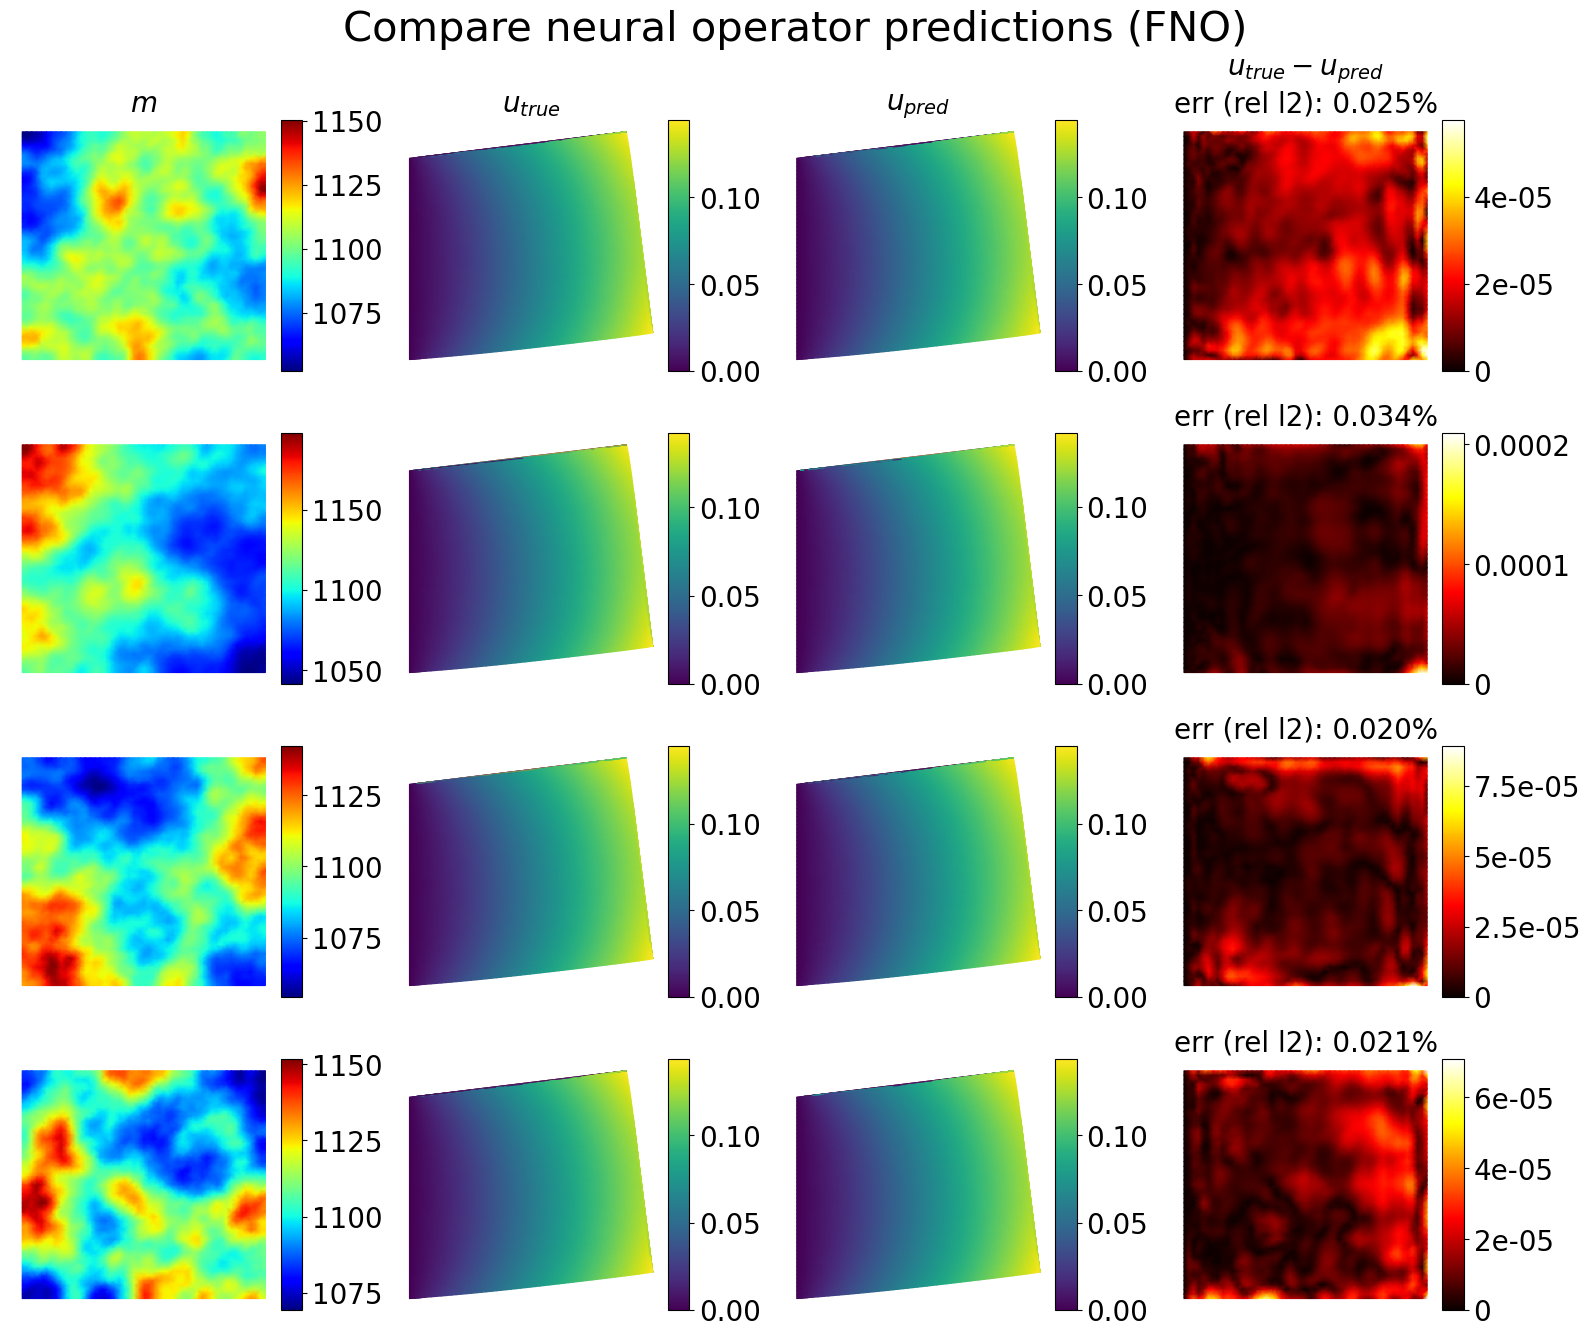

In [20]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_m_test = i_m_test[:, :, 0]

    if apply_dirichlet_bc_flag:
        bc_node_ids = data.u_grid_dirichlet_boundary_nodes
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, bc_node_ids)

        # verify for i_truth
        i_truthx = i_truth[bc_node_ids[:,0], bc_node_ids[:,1], 0]
        i_truthy = i_truth[bc_node_ids[:,0], bc_node_ids[:,1], 1]
        bc_err_x, bc_err_y = np.abs(i_truthx).max(), np.abs(i_truthy).max()
        if bc_err_x > 1.0e-9 or bc_err_y > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : ({:.3e}, {:.3e})'.format(bc_err_x, bc_err_y))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):

        if j == 0:
            cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])
        elif j == cols - 1:
            cbar = field_plot_grid(axs[i, j],\
                        uvec[j], \
                        grid_x, \
                        grid_y, \
                        cmap = cmaps[j], \
                        add_displacement_to_nodes = False, \
                        is_displacement = True)
        else:
            cbar = field_plot_grid(axs[i, j],\
                        uvec[j], \
                        grid_x, \
                        grid_y, \
                        cmap = cmaps[j], \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions ({})'.format(model.name), fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
